In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

In [2]:
class Args(object):
    def __init__(self):
        self.data_path= 'data'
        self.datasetG= 'masked_pwc'
        self.datasetD= 'pwc'
        self.batch_size= 128
        self.model= 'unet1d'
        self.modelG= 'unet1d'
        self.modelD= 'gan_discriminator'
        self.lrG= 0.001
        self.lrD= 0.001
        self.num_epochs= 10
        self.n_data = 1000
        self.min_sep = 5
        self.valid_interval= 2
        self.save_interval= 2
        self.seed = 0
        self.output_dir= 'experiments'
        self.experiment= None

        self.resume_training= False
        self.restore_file= None

        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 10
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False
        self.g_d_update_ratio = 2
        self.in_channels= 1
        self.hidden_size = 64
        self.bias= False
        self.test_num = 0
        self.wtl2 = 0 # l2 loss weighting
        # UNET
        self.residual = False
args=Args()

In [3]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
utils.setup_experiment(args)
utils.init_logging(args)

[2020-09-04 14:57:14] COMMAND: /home/michael/python-virtual-environments/bfcnn/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/michael/.local/share/jupyter/runtime/kernel-57f42398-1b63-40fd-bba5-112f55ba4d03.json
[2020-09-04 14:57:14] Arguments: {'data_path': 'data', 'datasetG': 'masked_pwc', 'datasetD': 'pwc', 'batch_size': 128, 'model': 'unet1d', 'modelG': 'unet1d', 'modelD': 'gan_discriminator', 'lrG': 0.001, 'lrD': 0.001, 'num_epochs': 10, 'n_data': 1000, 'min_sep': 5, 'valid_interval': 2, 'save_interval': 2, 'seed': 0, 'output_dir': 'experiments', 'experiment': 'unet1d-Sep-04-14:57:14', 'resume_training': False, 'restore_file': None, 'no_save': False, 'step_checkpoints': False, 'no_log': False, 'log_interval': 10, 'no_visual': False, 'visual_interval': 100, 'no_progress': False, 'draft': False, 'dry_run': False, 'g_d_update_ratio': 2, 'in_channels': 1, 'hidden_size': 64, 'bias': False, 'test_num': 0, 'wtl2': 0, 'residual': False, 'experiment_dir': 'experiments/unet1d/un

### Define models and optimizers

In [4]:
# IF NOT RETRAINING
# Build data loaders, a model and an optimizer

G,D = models.build_model_gan(args)
netG = G.to(device)
netD = D.to(device)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# 2 optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=args.lrG,betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=args.lrD,betas=(0.5, 0.999))

# Schedulers to reduce the learning rate
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, 50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, 50, gamma=0.5)

logging.info(f"Built a generator model consisting of {sum(p.numel() for p in netG.parameters()):,} parameters")
logging.info(f"Built a discriminator model consisting of {sum(p.numel() for p in netD.parameters()):,} parameters")

if args.resume_training and args.restore_file is not None:
    state_dict = utils.load_checkpoint_GAN(args, netG, netD, optimizerG, optimizerD)
    global_step = state_dict['last_step']
    start_epoch = int(state_dict['last_step']/(403200/state_dict['args'].batch_size))+1
else:
    global_step = -1
    start_epoch = 0

[2020-09-04 14:57:17] Built a generator model consisting of 72,000 parameters
[2020-09-04 14:57:17] Built a discriminator model consisting of 692,224 parameters


In [5]:
# build_dataset is a function in utils/data/__init__.py
train_loaderG, valid_loaderG, _ = data.build_dataset(args.datasetG,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)
train_loaderD, _, _ = data.build_dataset(args.datasetD,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

In [27]:
# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in ([\
                                    "G_loss","G_loss_L2","G_loss_adv","accD","accD_fake","accD_real"])}

# valid_meters = {name: utils.AverageMeter() for name in ([\
#                                     "G_loss","G_loss_L2","G_loss_adv","D_loss","D_loss_fake","D_loss_real"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None

epoch 00:  38%|███▊      | 3/8 [00:00<00:01,  3.72it/s, G_loss=0.740 (0.788), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.512 (0.527), accD_fake=0.492 (0.469), accD_real=0.532 (0.586), lr=1.0e-03]

[0/10][0/8]	Loss_D: 1.4086	Loss_G: 0.7398	D(x): 0.5013	D(G(z)): 0.4995 / 0.4838


epoch 01:  12%|█▎        | 1/8 [00:00<00:02,  2.98it/s, G_loss=0.746 (0.714), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.543 (0.543), accD_fake=0.555 (0.555), accD_real=0.531 (0.531), lr=1.0e-03]

[1/10][0/8]	Loss_D: 1.4165	Loss_G: 0.7467	D(x): 0.4983	D(G(z)): 0.4951 / 0.4846


epoch 02:  12%|█▎        | 1/8 [00:00<00:02,  2.96it/s, G_loss=0.732 (0.685), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.547 (0.547), accD_fake=0.680 (0.680), accD_real=0.414 (0.414), lr=1.0e-03]

[2/10][0/8]	Loss_D: 1.3683	Loss_G: 0.7332	D(x): 0.4837	D(G(z)): 0.4577 / 0.4855


epoch 03:  38%|███▊      | 3/8 [00:00<00:01,  3.90it/s, G_loss=0.701 (0.815), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.405 (0.531), accD_fake=0.478 (0.547), accD_real=0.332 (0.516), lr=1.0e-03]

[3/10][0/8]	Loss_D: 1.4851	Loss_G: 0.6988	D(x): 0.4658	D(G(z)): 0.5034 / 0.5034


epoch 04:  38%|███▊      | 3/8 [00:00<00:01,  3.90it/s, G_loss=0.775 (0.756), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.564 (0.461), accD_fake=0.567 (0.406), accD_real=0.562 (0.516), lr=1.0e-03]

[4/10][0/8]	Loss_D: 1.3649	Loss_G: 0.7764	D(x): 0.5094	D(G(z)): 0.4885 / 0.4695


epoch 05:  38%|███▊      | 3/8 [00:00<00:01,  3.82it/s, G_loss=0.760 (0.763), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.522 (0.457), accD_fake=0.430 (0.461), accD_real=0.614 (0.453), lr=1.0e-03]

[5/10][0/8]	Loss_D: 1.3884	Loss_G: 0.7612	D(x): 0.5164	D(G(z)): 0.5089 / 0.4712


epoch 06:  12%|█▎        | 1/8 [00:00<00:02,  2.89it/s, G_loss=0.707 (0.671), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.504 (0.504), accD_fake=0.477 (0.477), accD_real=0.531 (0.531), lr=1.0e-03]

[6/10][0/8]	Loss_D: 1.4145	Loss_G: 0.7075	D(x): 0.5148	D(G(z)): 0.5114 / 0.4960


epoch 07:  38%|███▊      | 3/8 [00:00<00:01,  3.81it/s, G_loss=0.770 (0.778), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.444 (0.547), accD_fake=0.357 (0.602), accD_real=0.530 (0.492), lr=1.0e-03]

[7/10][0/8]	Loss_D: 1.4826	Loss_G: 0.7696	D(x): 0.5066	D(G(z)): 0.5314 / 0.4681


epoch 08:  38%|███▊      | 3/8 [00:00<00:01,  3.92it/s, G_loss=0.864 (0.763), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.512 (0.523), accD_fake=0.448 (0.562), accD_real=0.576 (0.484), lr=1.0e-03]

[8/10][0/8]	Loss_D: 1.4052	Loss_G: 0.8673	D(x): 0.5182	D(G(z)): 0.5113 / 0.4369


epoch 09:  38%|███▊      | 3/8 [00:00<00:01,  3.68it/s, G_loss=0.728 (0.776), G_loss_L2=0.000 (0.000), G_loss_adv=0.000 (0.000), accD=0.485 (0.527), accD_fake=0.325 (0.547), accD_real=0.646 (0.508), lr=1.0e-03]

[9/10][0/8]	Loss_D: 1.4551	Loss_G: 0.7267	D(x): 0.5236	D(G(z)): 0.5362 / 0.4897


[2020-09-04 15:24:51] Done training!                                                                                                                                                                              


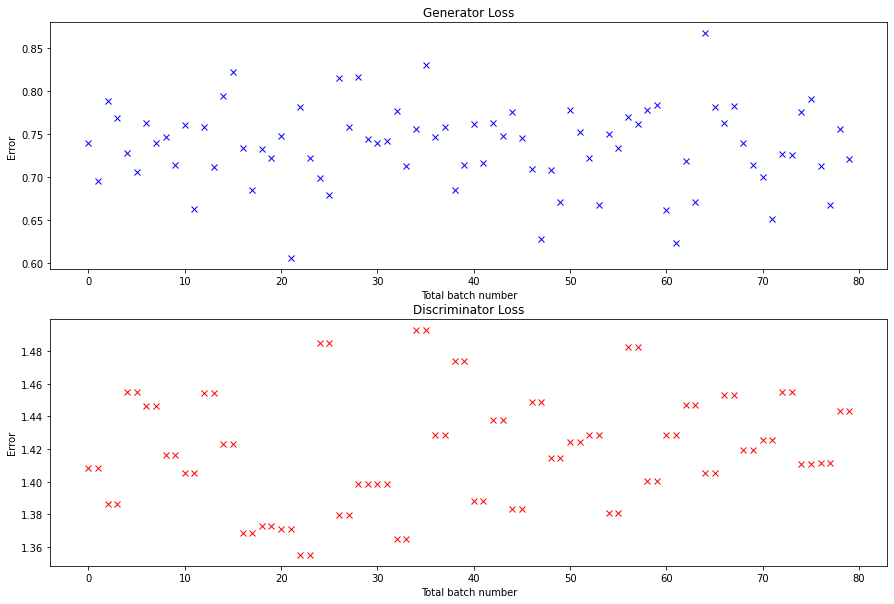

In [40]:
fake_label = 0.
real_label = 1.
# fake_label = [0.,0.1]
# real_label = [0.9,1.]

G_losses = []
D_losses = []

if args.wtl2 > 0:
    use_mse = True
else:
    use_mse = False



# TRAINING
for epoch in range(start_epoch, args.num_epochs):
    if args.resume_training:
        if epoch %10 == 0:
            optimizerG.param_groups[0]["lr"] /= 2
            print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loaderG, epoch)
    for meter in train_meters.values():
        meter.reset()

    for batch_id, ((clean, mask),real) in enumerate(zip(train_bar,train_loaderD)):
        
        ###############################
        # First train the discriminator
        ###############################
        # Only update discriminator based on update ratio
        real_cpu = real.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,),real_label,device=device)

        if batch_id % args.g_d_update_ratio == 0:
            netD.zero_grad()

            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
            # Accuracy is  the number of 1's when all samples are real
            preds = [1 if o > 0.5 else 0 for o in output]
            accD_real = np.sum(preds)/b_size
        
        ## Train with all-fake batch
        # Generate fake signal batch with G
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = netG(inputs,mask_inputs)
        fake = (1-mask_inputs)*raw_outputs + mask_inputs*inputs
        
        label.fill_(fake_label)
        if batch_id % args.g_d_update_ratio == 0:
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)

            # Accuracy is  the number of 1's when all samples are fake
            # Note I flipped the pred logic for fakes
            preds = [1 if o < 0.5 else 0 for o in output]
            accD_fake = np.sum(preds)/b_size
            accD = (accD_fake+accD_real)/2
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake

            # Update D
            optimizerD.step()
        
        ###############################
        # Next, train the generator
        ###############################
        netG.zero_grad() # train() or zero_grad()?
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        if use_mse:
            # Calculate G's loss based on this output
            errG_D = criterion(output, label)
            # MSE Loss
            errG_l2 = F.mse_loss(fake, inputs, reduction="sum") / (inputs.size(0) * 2)
            errG =  (1-args.wtl2) * errG_D + args.wtl2 * errG_l2
        else:
            errG_l2 = torch.zeros(1)
            errG = criterion(output, label)
            errG_D = errG
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        

        
        # Output training stats
        if batch_id % 50 == 0:
            if use_mse:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f + %.4f = %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG), \
                     errD.item(), errG_D.item(), errG_l2, errG.item(), D_x, D_G_z1, D_G_z2))
            else: 
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        global_step += 1
        
        # TO DO, only run loss on masked part of output
        # TO DO, incorporate MSE loss into GAN?
        # loss = F.mse_loss(outputs, inputs, reduction="sum") / (inputs.size(0) * 2)
        
        # New train_meters
        train_meters["G_loss"].update(errG.item())
        if use_mse:
            train_meters["G_loss_L2"].update(errG_l2.item())
            train_meters["G_loss_adv"].update(errG_D.item())
        else:
            train_meters["G_loss_L2"].update(0)
            train_meters["G_loss_adv"].update(0)
        train_meters["accD"].update(accD.item())
        train_meters["accD_fake"].update(accD_fake.item())
        train_meters["accD_real"].update(accD_real.item())

        train_bar.log(dict(**train_meters, lr=optimizerG.param_groups[0]["lr"]), verbose=True)

        if writer is not None and global_step % args.log_interval == 0:
            writer.add_scalar("lr", optimizerG.param_groups[0]["lr"], global_step)
            writer.add_scalar("G_loss/train", errG.item() , global_step)
            writer.add_scalar("G_loss_L2/train", errG_l2.item() , global_step)
            writer.add_scalar("G_loss_adv/train", errG_D.item() , global_step)
            writer.add_scalar("accD/train", accD.item() , global_step)
            writer.add_scalar("accD_fake/train", accD_fake.item() , global_step)
            writer.add_scalar("accD_real/train", accD_real.item() , global_step)
            gradients = torch.cat([p.grad.view(-1) for p in netG.parameters() if p.grad is not None], dim=0)
            writer.add_histogram("gradients", gradients, global_step)
            sys.stdout.flush()

# Rewrite validation loop for the right metrics
    if epoch % args.valid_interval == 0:
#         netG.eval()
#         for meter in valid_meters.values():
#             meter.reset()

#         valid_bar = utils.ProgressBar(valid_loaderG)
        
#         for sample_id, (clean, mask) in enumerate(valid_bar):
#             with torch.no_grad():
#                 inputs = clean.to(device)
#                 mask_inputs = mask.to(device)
#                 # only use the mask part of the outputs
#                 raw_output = netG(inputs,mask_inputs)
#                 output = (1-mask_inputs)*raw_output + mask_inputs*inputs
#                 valid_psnr = utils.psnr(inputs, output)
#                 valid_meters["valid_psnr"].update(valid_psnr.item())
#                 valid_ssim = utils.ssim(inputs, output)
#                 valid_meters["valid_ssim"].update(valid_ssim.item())

#         if writer is not None:
#             writer.add_scalar("psnr/valid", valid_meters['valid_psnr'].avg, global_step)
#             writer.add_scalar("ssim/valid", valid_meters['valid_ssim'].avg, global_step)
#             sys.stdout.flush()
#             utils.save_checkpoint_GAN(args, global_step, netG, netD, optimizerG, optimizerD, score=valid_meters["valid_psnr"].avg, mode="max")

        logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizerG.param_groups[0]["lr"])))
        
    schedulerG.step()
    schedulerD.step()
    
# Save the loss curve plot
utils.save_losses_curve(G_losses,D_losses,args)
# logging.info(f"Done training! Best PSNR {utils.save_checkpoint_GAN.best_score:.3f} obtained after step {utils.save_checkpoint.best_step}.")
logging.info(f"Done training!")

In [ ]:
#   train_meters["D_loss"].update(errD.item())
#         train_meters["D_loss_fake"].update(errD_fake.item())
#         train_meters["D_loss_real"].update(errD_real.item)
train_meters["D_loss_real"].val

### Testing

In [ ]:
# Best PSNR 28.560
def mask_idx_f(mask):
    mask_start = int(np.argmin(mask[0]))
    mask_length = int((1-mask[0]).sum())
    mask_idx = range(mask_start,mask_start+mask_length)
     # No mask indices
    before = np.arange(mask.shape[2])[:mask_start]
    after = np.arange(mask.shape[2])[mask_start+mask_length:]
    no_mask_idx = np.append(before,after)
    return mask_idx,before, after, mask_length, mask_start

def print_one(loader,model1,model2):
    np.random.seed()
    clean,mask = next(iter(loader))
    outputs1 = model1(clean.to(device),mask.to(device)).cpu()
    outputs2 = model2(clean.to(device),mask.to(device)).cpu()
    
    mask_idx,before_mask,after_mask,mask_length, mask_start = mask_idx_f(mask)

    out1 = outputs1[0] * (1-mask[0]) + clean[0]*mask[0]
    out2 = outputs2[0] * (1-mask[0]) + clean[0]*mask[0]

    print("Mask Length: {}\tMask Start: {}".format(mask_length,mask_start))
    
    plt.figure(figsize=[15,14])
    plt.subplot(4,1,1)
    plt.plot(clean[0,0,:],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("True signal")

    plt.subplot(4,1,2)
    masked = clean[0]*mask[0]
    masked_plot = masked[:mask_start,]
    plt.plot(before_mask,masked[0,before_mask],'xb')
    plt.plot(after_mask,masked[0,after_mask],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("Masked signal")

    plt.subplot(4,1,3)
    plt.plot(out1[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("GAN denoised signal")
    print(outputs1[0,:].detach())
    
    plt.subplot(4,1,4)
    plt.plot(out2[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("MSE denoised signal")
#     return out1,out2, clean

In [ ]:
# Load MSE model
mse = models.build_model(args)
netMSE = mse.to(device)

MODEL_PATH = "models/trained/unet1d_partialconv_10kdata_30epoch_3minsep_08_14_20.pth"
netMSE.load_state_dict(torch.load(MODEL_PATH))
netMSE.to(device)

In [ ]:
# Test loader is shuffled and allows test_num to force a certain mask shape
_, _, test_loader = data.build_dataset(args.datasetG,
                                                   1000, 
                                                   batch_size=1,
                                                   fix_datapoints=False,
                                                   min_sep = args.min_sep,
                                                   test_num = 2)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
print_one(test_loader,netG,netMSE)

In [ ]:
## Saving the model (Old way)
MODEL_PATHG = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
MODEL_PATHD = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
torch.save(netG.state_dict(), MODEL_PATHG)
torch.save(netD.state_dict(), MODEL_PATHD)

In [ ]:
        # Introducing label noise
#         label = torch.rand((b_size,),device=device)*(fake_label[1]-fake_label[0])+fake_label[0]


In [ ]:
# IF RETRAINING
G,D = models.build_model_gan(args)
netG = G.to(device)
netD = D.to(device)

G_PATH = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
D_PATH = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
netG.load_state_dict(torch.load(G_PATH))
netD.load_state_dict(torch.load(D_PATH))

# 2 optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=args.lrG,betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=args.lrD,betas=(0.5, 0.999))

# Schedulers to reduce the learning rate
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, 50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, 50, gamma=0.5)

logging.info(f"Built a generator model consisting of {sum(p.numel() for p in netG.parameters()):,} parameters")
logging.info(f"Built a discriminator model consisting of {sum(p.numel() for p in netD.parameters()):,} parameters")

global_step = -1
start_epoch = 0